In [ ]:
from rich.console import Console

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer

from ariel_experiments.characterize.canonical.tests.old.toolkit import (
    CanonicalToolKit as ctk,
)
import numpy as np
from scipy.spatial.distance import pdist, squareform
import numpy as np
import umap
import umap.plot
from ariel_experiments.utils.initialize import generate_random_individual
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from ariel_experiments.gui_vis.visualize_tree import visualize_tree_from_graph
from ariel_experiments.gui_vis.view_mujoco import view
import numpy as np
from scipy.sparse import csr_matrix


console = Console()


/home/salo/projects/ariel-zoo/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/salo/projects/ariel-zoo/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/salo/projects/ariel-zoo/.venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signa

In [2]:
from typing import Any

def plot_heatmap_row(
    matrices: list[np.ndarray],
    titles: list[str] = None,
    suptitle: str = None,
    figsize_per_plot: tuple[int, int] = (5, 6),
    cmap: str = 'viridis'
):
    """
    Plots a horizontal row of heatmaps with local color scaling.
    
    Args:
        matrices: List of matrices to plot
        titles: Optional list of titles for each subplot
        suptitle: Optional overall figure title
        figsize_per_plot: (width, height) for each subplot
        cmap: Colormap to use
    """
    num_plots = len(matrices)
    
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=num_plots, 
        figsize=(figsize_per_plot[0] * num_plots, figsize_per_plot[1]),
        squeeze=False
    )
    axes = axes.flatten()
    
    if suptitle:
        fig.suptitle(suptitle, fontsize=16)
    
    for i, matrix in enumerate(matrices):
        ax = axes[i]
        
        # Local color scaling for maximum contrast
        local_vmin = matrix.min()
        local_vmax = matrix.max()
        
        sns.heatmap(
            matrix,
            ax=ax,
            cmap=cmap,
            vmin=local_vmin,
            vmax=local_vmax,
            cbar_ax=None
        )
        
        if titles and i < len(titles):
            ax.set_title(titles[i])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [3]:
def plot_comparison_heatmaps(
    all_matrix_data: list[tuple[str, dict[int, Any]]], 
    max_show_radius: int
):
    """
    Plots a row of heatmaps for each radius.
    Row = Radius
    Column = Metric
    **Does NOT sum matrices (shows raw data for that radius).**
    """
    # 1. Iterate through radii (Rows of the visual)
    for r in range(max_show_radius + 1):
        row_matrices = []
        row_titles = []
        
        # 2. Iterate through metrics (Columns of the visual)
        for name, matrix_dict in all_matrix_data:
            # DIRECT ACCESS: Get the specific matrix for this radius
            if r in matrix_dict:
                matrix = matrix_dict[r]
            else:
                # Fallback if radius is missing (returns empty 1x1 or similar)
                # You might want to adjust the shape to match your data
                matrix = np.zeros((1, 1)) 
            
            row_matrices.append(matrix)
            row_titles.append(f"r:{r} {name}")
            
        # 3. Plot the specific row
        plot_heatmap_row(
            matrices=row_matrices, 
            titles=row_titles,
            suptitle=f"Comparison at Radius {r}" 
        )

In [4]:
def get_sorted_coords_from_matrix(matrix, *, max_first=True):
    """
    Returns coordinates sorted by matrix values from upper triangle only.
    
    Args:
        matrix: 2D numpy array (assumed symmetric)
        max_first: If True, sort descending (highest values first), 
                   otherwise ascending (lowest values first)
    
    Returns:
        List of (row, col) tuples sorted by matrix values (only upper triangle)
    """
    if matrix.size == 0:
        return []
    
    POPULATION_SIZE = matrix.shape[0]
    
    # Create mask for upper triangle (excluding diagonal)
    upper_triangle_mask = np.triu(np.ones((POPULATION_SIZE, POPULATION_SIZE), dtype=bool), k=1)
    
    # Get indices of upper triangle
    row_indices, col_indices = np.where(upper_triangle_mask)
    
    # Get values from upper triangle
    values = matrix[row_indices, col_indices]
        
    # Sort by values
    sorted_order = np.argsort(values)
    
    if max_first:
        sorted_order = sorted_order[::-1]
    
    # Apply sorted order to coordinates
    sorted_rows = row_indices[sorted_order]
    sorted_cols = col_indices[sorted_order]
    
    return list(zip(sorted_rows, sorted_cols))

In [5]:
def sum_matrices_up_to_radius(
    matrix_dict: dict[int, np.ndarray],
    max_chosen_radius: int
):
    result = np.zeros((POPULATION_SIZE, POPULATION_SIZE))
    
    for radius in sorted(matrix_dict.keys()):
        if radius <= max_chosen_radius:
            result += matrix_dict[radius] 
    
    return result

In [6]:
def plot_heatmaps_per_radius(matrix_dicts, max_radius: int):
    """
    For each radius 0..max_radius:
      1. Sums the matrices up to that radius.
      2. Calls plot_heatmap_row for that specific level.
    """
    for r in range(max_radius + 1):
        row_matrices = []
        row_titles = []

        for name, radius_map in matrix_dicts.items():
            # Sum matrix up to current radius r
            summed_matrix = sum_matrices_up_to_radius(radius_map, r)
            
            row_matrices.append(summed_matrix)
            row_titles.append(f"{name} (r={r})")

        # Plot the row for this radius
        plot_heatmap_row(matrices=row_matrices, titles=row_titles)

In [7]:
def view_horizontal_groups(robot_tuples, titles=None):
    """
    Plots horizontal groups without rescaling images of different sizes.
    Uses pixel-perfect width_ratios.
    """
    
    # --- 1. Pre-fetch ALL images to get dimensions ---
    # We flatten the structure but keep track of where groups split
    processed_items = [] # Will store dicts: {'type': 'img', 'data': img} or {'type': 'gap'}
    
    # Config for spacing (in pixels, approximately)
    GROUP_GAP_PX = 100  # The big gap between tuples
    ROBOT_GAP_PX = 20   # The small gap between robots in a tuple
    DPI = 100           # Screen dots per inch
    
    max_height = 0
    
    group_start_indices = [] # To help us place titles later
    current_index = 0

    for i, group in enumerate(robot_tuples):
        # Record where this group starts in the flat list
        group_start_indices.append(current_index)
        
        for j, robot in enumerate(group):
            # Generate the image
            img = np.array(view(robot, return_img=True, remove_background=True, tilted=True))
            h, w = img.shape[:2]
            
            # Update global max height (defines the strip height)
            if h > max_height:
                max_height = h
            
            processed_items.append({
                'type': 'img',
                'data': img,
                'width': w,
                'height': h
            })
            current_index += 1
            
            # Add a small gap after every robot, EXCEPT the last one in the group
            if j < len(group) - 1:
                processed_items.append({'type': 'gap', 'width': ROBOT_GAP_PX})
                current_index += 1

        # Add a large gap after every group, EXCEPT the last group
        if i < len(robot_tuples) - 1:
            processed_items.append({'type': 'gap', 'width': GROUP_GAP_PX})
            current_index += 1

    # --- 2. Calculate Figure Dimensions ---
    # Total width is sum of all image widths + sum of all gap widths
    total_width_px = sum(item['width'] for item in processed_items)
    
    # Calculate Figure size in Inches (Pixels / DPI)
    fig_width_in = total_width_px / DPI
    fig_height_in = max_height / DPI
    
    # Add a little buffer for titles at the top (e.g., 0.5 inches)
    title_buffer_in = 0.5
    fig_height_total = fig_height_in + title_buffer_in

    # --- 3. Create Figure with Exact Aspect Ratio ---
    fig = plt.figure(figsize=(fig_width_in, fig_height_total), dpi=DPI)
    
    # List of widths to tell GridSpec exactly how much space each col gets
    widths = [item['width'] for item in processed_items]
    
    # One big row, N columns (images + gaps)
    gs = gridspec.GridSpec(1, len(processed_items), figure=fig, width_ratios=widths)
    
    # Remove default spacing, we are handling it manually with 'gap' columns
    plt.subplots_adjust(left=0, right=1, bottom=0, top=fig_height_in/fig_height_total, wspace=0, hspace=0)

    # --- 4. Plotting ---
    axes_map = {} # Map index to ax object to help with titles

    for idx, item in enumerate(processed_items):
        if item['type'] == 'gap':
            # Skip this column, let it be empty whitespace
            continue
            
        # Create subplot
        ax = fig.add_subplot(gs[0, idx])
        
        # Display Image
        # anchor='S' aligns image to Bottom (South) if it's shorter than max_height
        # 'C' would center it. 'N' would align top.
        ax.imshow(item['data'], aspect='equal', interpolation='none', origin='upper')
        
        # Ensure the axes limits match the max_height so alignment works
        # This keeps the "ceiling" consistent even for short images
        ax.set_ylim(max_height, 0) 
        ax.set_xlim(0, item['width'])
        
        ax.axis('off')
        axes_map[idx] = ax

    # --- 5. Titles ---
    if titles:
        # We need to find the center of each group
        # We iterate through the original group structure to find start/end indices
        flat_ptr = 0
        
        for i, group in enumerate(robot_tuples):
            # Find the first ax in this group
            start_ax = axes_map[flat_ptr]
            
            # Advance pointer to find the last ax in this group
            # Structure in flattened list: [Img, Gap, Img, Gap, Img] ... [Big Gap] ...
            # Length of group items = (len(group) * 2) - 1
            items_in_group = (len(group) * 2) - 1
            end_ptr = flat_ptr + items_in_group - 1
            
            # If the group has only 1 robot, start and end are same
            if end_ptr not in axes_map: 
                # This happens if end_ptr points to a gap (logic check), 
                # but based on math above, end_ptr should always hit an image.
                end_ax = start_ax
            else:
                end_ax = axes_map[end_ptr]
            
            # Calculate positions in Figure Coordinates (0 to 1)
            bbox_start = start_ax.get_position()
            bbox_end = end_ax.get_position()
            
            center_x = (bbox_start.x0 + bbox_end.x1) / 2
            
            # Place Title
            fig.text(center_x, 1.0 - (0.2 / fig_height_total), titles[i], 
                     ha='center', va='top', fontsize=12, weight='bold')
            
            # Advance pointer past this group AND the group gap
            flat_ptr += items_in_group + 1

    plt.show()

In [8]:
def plot_rows_for_radii(
    matrix_dicts,
    population, 
    max_radius: int, 
    pair_rank: int = 0
):
    """
    Iterates through radii 0..max_radius. For each metric in matrix_dicts:
      1. Sums the matrix up to current radius.
      2. Finds the pair at `pair_rank`.
      3. Plots the row of comparisons.
    """
    for r in range(max_radius + 1):
        robots_row = []
        titles_row = []

        for name, radius_map in matrix_dicts.items():
            # 1. Sum matrix up to current radius
            matrix = sum_matrices_up_to_radius(radius_map, r)

            # 2. Determine sort order: UMAP implies distance (low is good), others imply similarity (high is good)
            max_first = "umap" not in name.lower()
            coords = get_sorted_coords_from_matrix(matrix, max_first=max_first)

            # 3. Get specific pair indices safely
            if coords and pair_rank < len(coords):
                i, j = coords[pair_rank]
            else:
                i, j = (0, 0) # Fallback if list is empty or rank out of bounds

            # 4. Prepare Graphics
            # Convert indices to int for safe lookup
            idx_i, idx_j = int(i), int(j)
            
            robots_row.append([
                population[idx_i].to_graph(), 
                population[idx_j].to_graph()
            ])
            
            titles_row.append(
                f"r:{r} {name}: ({idx_i},{idx_j}) sim={matrix[idx_i, idx_j]:.3f}"
            )

        # 5. Display the row
        view_horizontal_groups(robots_row, titles=titles_row)

In [9]:
def apply_tfidf_transformer(matrix):
    transformer = TfidfTransformer()
    tfidf_matrix = transformer.fit_transform(matrix)
    return cosine_similarity(tfidf_matrix)

def do_umap(radius_matrix):
    return umap.UMAP(metric='cosine', n_neighbors=2).fit_transform(radius_matrix)

def embeddings_to_dist_matrix(embeddings):
    condensed_distances = pdist(embeddings, metric='euclidean')
    return squareform(condensed_distances)

---

In [10]:
POPULATION_SIZE = 1000
NUM_OF_MODULES = 20

MAX_RADIUS = None

CONFIG = ctk.SimilarityConfig(
    max_tree_radius=MAX_RADIUS,
    radius_strategy=ctk.RadiusStrategy.NODE_LOCAL

)

In [11]:
POPULATION = [
    ctk.from_graph(generate_random_individual(NUM_OF_MODULES)) for _ in range(POPULATION_SIZE)
]

subtrees = [
    ctk.collect_tree_hash_config_mode(individual, config=CONFIG)
    for individual in POPULATION
]

In [12]:
count_matrix_dict = ctk.get_count_matrix(subtrees, CONFIG) 

cos_matrix_dict = ctk.matrix_dict_applier(count_matrix_dict, cosine_similarity)
tfidf_matrix_dict = ctk.matrix_dict_applier(count_matrix_dict, apply_tfidf_transformer)

umap_dict = ctk.matrix_dict_applier(count_matrix_dict, do_umap)
umapdist_matrix_dict = ctk.matrix_dict_applier(umap_dict, embeddings_to_dist_matrix)

In [13]:
# matrix stoff used for similarity!

ALL_MATRIX_DATA = [
    ("umapdist_matrix_dict", umapdist_matrix_dict),
    ("cos_matrix_dict", cos_matrix_dict),
    ("tfidf_matrix_dict", tfidf_matrix_dict),
]

MAX_INFO_RADIUS = 9

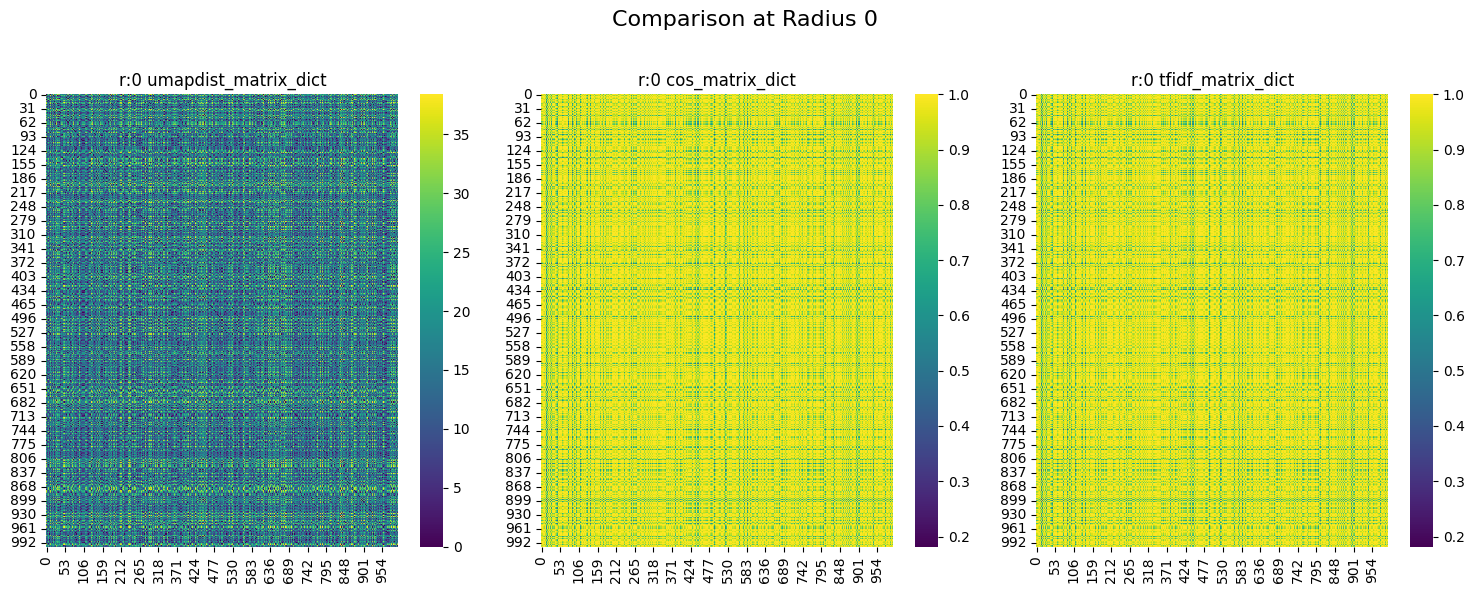

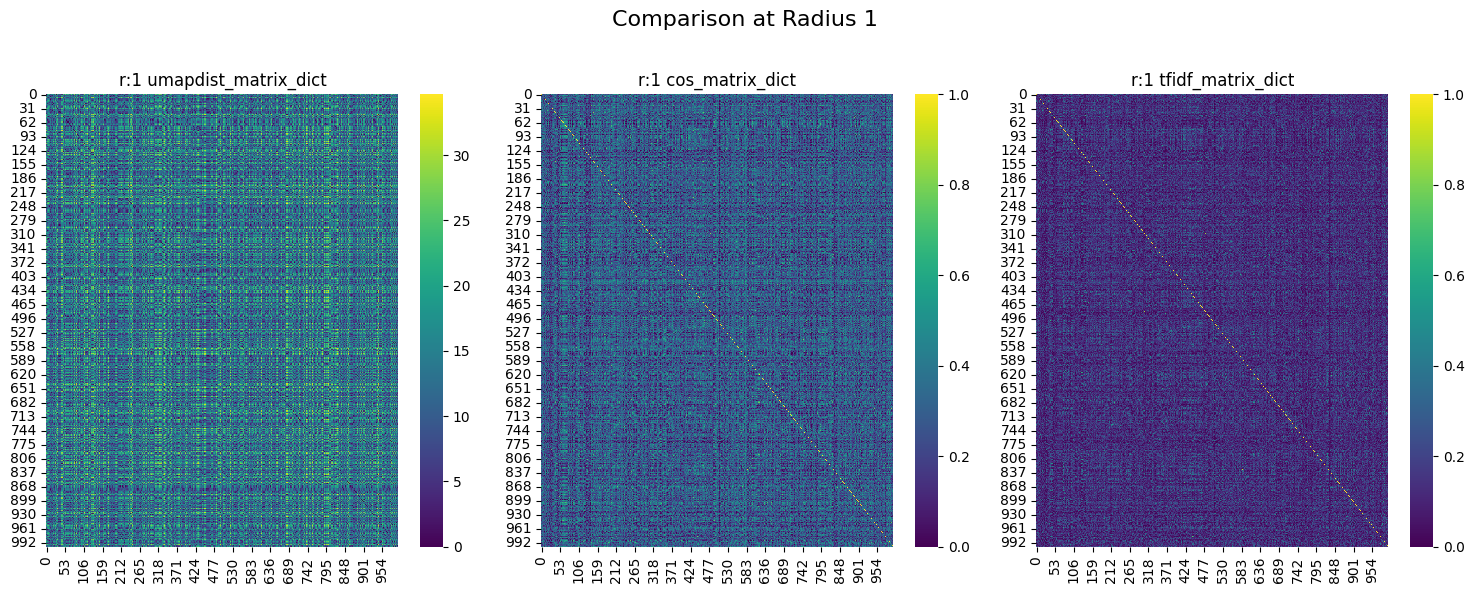

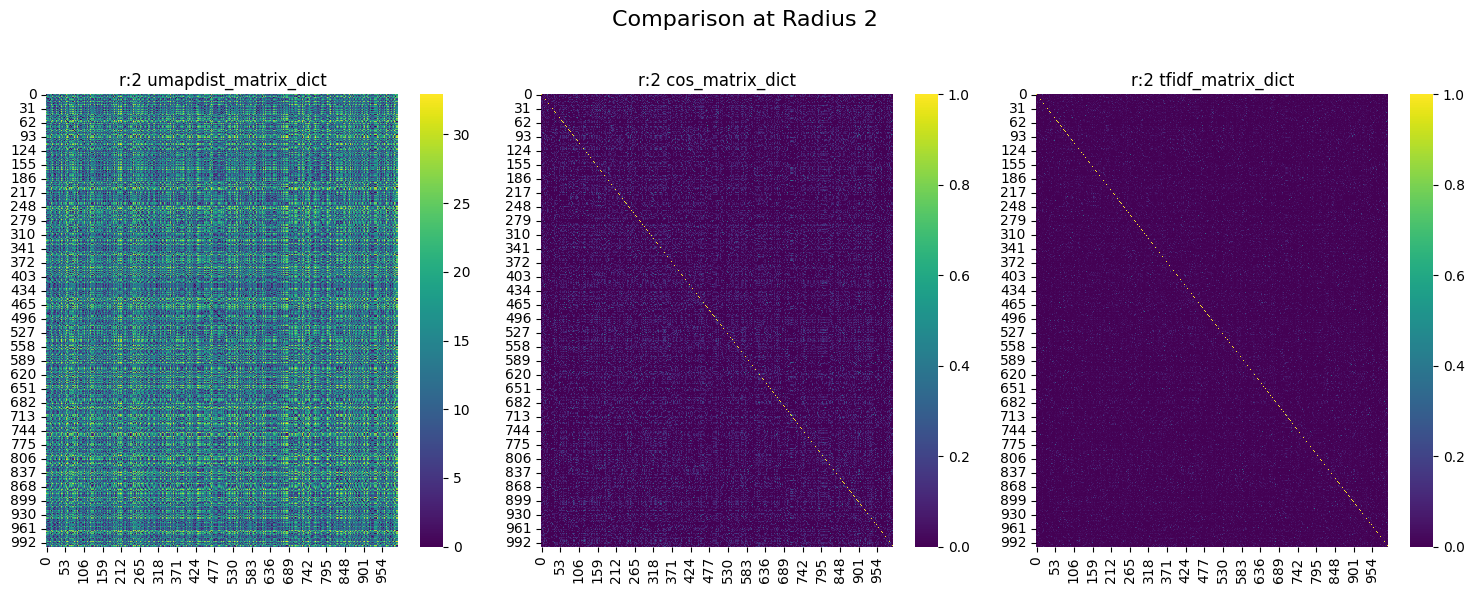

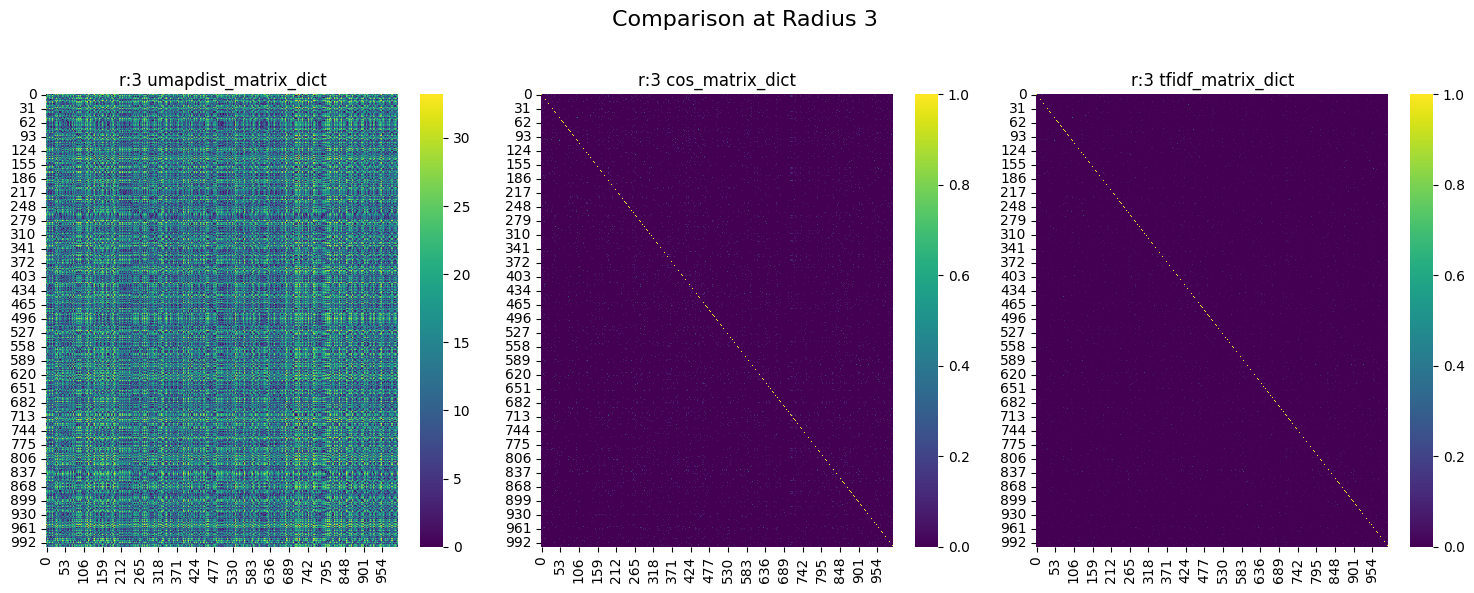

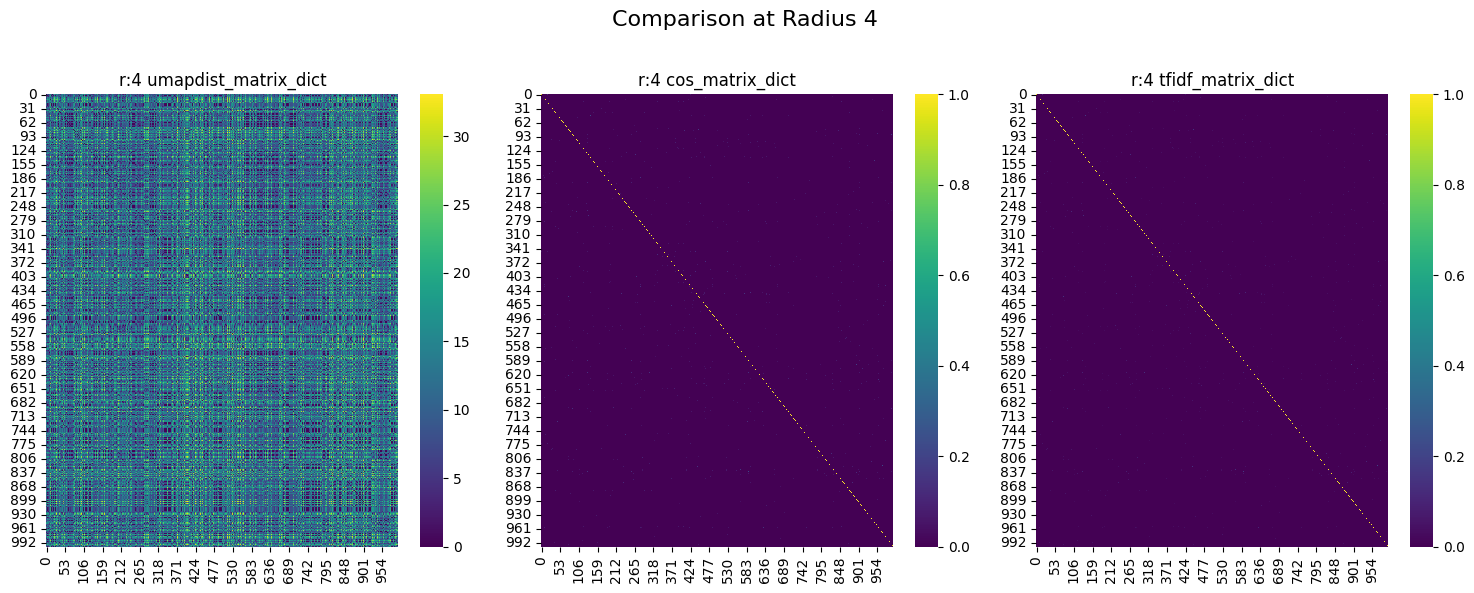

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plot_comparison_heatmaps(ALL_MATRIX_DATA, MAX_INFO_RADIUS)                                   │
│   2                                                                                              │
│                                                                                                  │
│ in plot_comparison_heatmaps:30                                                                   │
│                                                                                                  │
│   27 │   │   │   row_titles.append(f"r:{r} {name}")                                              │
│   28 │   │                                                                                       │
│   29 │   │   # 3. Plot the specific row                                                          │
│ ❱ 30 │   │   plot_heatmap_row(                                                                   │
│   31 │   │   │   matrices=row_matrices,                                                          │
│   32 │   │   │   titles=row_titles,                                                              │
│   33 │   │   │   suptitle=f"Comparison at Radius {r}"                                            │
│                                                                                                  │
│ in plot_heatmap_row:53                                                                           │
│                                                                                                  │
│   50 │   │   │   ax.set_title(titles[i])                                                         │
│   51 │                                                                                           │
│   52 │   plt.tight_layout(rect=[0, 0, 1, 0.96])                                                  │
│ ❱ 53 │   plt.show()                                                                              │
│   54                                                                                             │
│                                                                                                  │
│ /home/salo/projects/ariel-zoo/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py:613 in     │
│ show                                                                                             │
│                                                                                                  │
│    610 │   explicitly there.                                                                     │
│    611 │   """                                                                                   │
│    612 │   _warn_if_gui_out_of_main_thread()                                                     │
│ ❱  613 │   return _get_backend_mod().show(*args, **kwargs)                                       │
│    614                                                                                           │
│    615                                                                                           │
│    616 def isinteractive() -> bool:                                                              │
│                                                                                                  │
│ /home/salo/projects/ariel-zoo/.venv/lib/python3.12/site-packages/matplotlib_inline/backend_inlin │
│ e.py:90 in show                                                                                  │
│                                                                                                  │
│    87 │   │   close = InlineBackend.instance().close_figures                                     │
│    88 │   try:                                             

In [14]:
plot_comparison_heatmaps(ALL_MATRIX_DATA, MAX_INFO_RADIUS)

In [ ]:
# max_chosen_radius = 3

# tfidf_sum_matrix =  sum_matrices_up_to_radius(tfidf_matrix_dict, max_chosen_radius)
# cos_sum_matrix = sum_matrices_up_to_radius(cos_matrix_dict, max_chosen_radius)
# umapdist_sum_matrix = sum_matrices_up_to_radius(umapdist_matrix_dict, max_chosen_radius)

In [ ]:
# all_summed_matrix_data = {
#     "tfidf_matrix_dict_sum" : tfidf_sum_matrix,
#     "cos_matrix_dict_sum":  cos_sum_matrix,
#     "umapdist_matrix_dict_sum" : umapdist_sum_matrix
# }

# plot_heatmap_row(matrices=all_summed_matrix_data.values(), titles=list(all_summed_matrix_data.keys()))

In [ ]:
# def view_multiple_horizontal(robot_tuples, titles=None, figsize_per_plot=(5, 5)):
#     """
#     View multiple robot tuples in horizontal rows.
    
#     Args:
#         robot_tuples: List of tuples, each containing multiple robots to display horizontally
#         titles: Optional list of titles, one per tuple (row)
#         figsize_per_plot: (width, height) for each subplot
#     """
#     n_rows = len(robot_tuples)
#     n_cols = max(len(t) for t in robot_tuples)
    
#     fig, axes = plt.subplots(
#         n_rows, n_cols,
#         figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows)
#     )
    
#     # Handle single row case
#     if n_rows == 1:
#         axes = axes.reshape(1, -1)
    
#     # Plot each tuple
#     for row_idx, robot_tuple in enumerate(robot_tuples):
#         for col_idx, robot in enumerate(robot_tuple):
#             ax = axes[row_idx, col_idx]
#             img = view(robot, return_img=True, remove_background=True, tilted=True)
#             ax.imshow(img)
#             ax.axis('off')
        
#         # Add title to first subplot of each row
#         if titles and row_idx < len(titles):
#             axes[row_idx, 0].set_title(titles[row_idx], loc='left', fontsize=12, pad=10)
        
#         # Hide unused subplots in this row
#         for col_idx in range(len(robot_tuple), n_cols):
#             axes[row_idx, col_idx].axis('off')
    
#     plt.tight_layout()
#     plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# def view_horizontal_groups(robot_tuples, titles=None, figsize_per_plot=(4, 4)):
#     """
#     Plots all robots in a single horizontal row.
#     Titles are centered HIGHER above their respective groups.
#     """
#     # 1. Flatten the list
#     all_robots = [robot for group in robot_tuples for robot in group]
#     n_total = len(all_robots)
    
#     # 2. Create ONE row
#     fig, axes = plt.subplots(
#         1, n_total, 
#         figsize=(figsize_per_plot[0] * n_total, figsize_per_plot[1])
#     )
    
#     # --- FIX 1: Make room at the top (Headroom) ---
#     # This pushes the images down so the titles don't get cut off
#     plt.subplots_adjust(top=0.8, wspace=0.2) 

#     if n_total == 1:
#         axes = [axes]
    
#     # 3. Plot images
#     for i, robot in enumerate(all_robots):
#         img = view(robot, return_img=True, remove_background=True, tilted=True)
#         axes[i].imshow(img)
#         axes[i].axis('off')
        
#     # 4. Smart Title Placement
#     if titles:
#         # Render to calculate new axis positions after subplots_adjust
#         fig.canvas.draw() 
        
#         current_idx = 0
#         for i, group in enumerate(robot_tuples):
#             if i >= len(titles): break
            
#             group_len = len(group)
#             start_ax = axes[current_idx]
#             end_ax = axes[current_idx + group_len - 1]
            
#             bbox_start = start_ax.get_position()
#             bbox_end = end_ax.get_position()
            
#             center_x = (bbox_start.x0 + bbox_end.x1) / 2
#             top_y = bbox_start.y1
            
#             # --- FIX 2: Increase the vertical offset ---
#             # Changed +0.02 to +0.08 to float it higher
#             fig.text(
#                 center_x, top_y + 0.2, 
#                 titles[i], 
#                 ha='center', va='bottom', fontsize=14, weight='bold'
#             )
            
#             current_idx += group_len

#     plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# def view_horizontal_groups(robot_tuples, titles=None, figsize_per_plot=(4, 4)):
#     """
#     Plots horizontal groups with specific spacing controls.
#     - robot_spacing: Gap between robots in the same tuple
#     - tuple_spacing: Gap between the tuples
#     """
    
#     # Configuration for spacing
#     tuple_spacing = 0.4  # Big gap between groups (0.4 = 40% of axis width)
#     robot_spacing = 0.05 # Small gap between robots (0.05 = 5% of axis width)
    
#     n_groups = len(robot_tuples)
    
#     # Calculate total width based on number of robots to keep aspect ratio decent
#     total_robots = sum(len(g) for g in robot_tuples)
    
#     # Create the Figure
#     fig = plt.figure(figsize=(figsize_per_plot[0] * total_robots, figsize_per_plot[1]))
    
#     # 1. Create the OUTER Grid (1 Row, N Groups)
#     # This handles the "Extra room between tuples"
#     outer_gs = gridspec.GridSpec(1, n_groups, figure=fig, wspace=tuple_spacing)
    
#     # We will store axes to calculate title positions later
#     group_axes_list = []

#     for i, group in enumerate(robot_tuples):
#         n_robots_in_group = len(group)
        
#         # 2. Create the INNER Grid (1 Row, M Robots) nested inside the Outer cell
#         # This handles the "Room between images"
#         inner_gs = gridspec.GridSpecFromSubplotSpec(
#             1, n_robots_in_group, 
#             subplot_spec=outer_gs[i], 
#             wspace=robot_spacing
#         )
        
#         current_group_axes = []
        
#         for j, robot in enumerate(group):
#             # Create the subplot in the inner grid
#             ax = fig.add_subplot(inner_gs[0, j])
            
#             # Plot the robot
#             img = view(robot, return_img=True, remove_background=True, tilted=True)
#             # img = view(robot, return_img=True, tilted=True)
#             ax.imshow(img)
#             ax.axis('off')
#             current_group_axes.append(ax)
            
#         group_axes_list.append(current_group_axes)

#     # Make room at the top for titles (Headroom)
#     plt.subplots_adjust(top=0.80)

#     # 3. Title Placement
#     if titles:
#         fig.canvas.draw()
        
#         # --- FIX: Determine a Common Y-Level for ALL titles ---
#         # We grab the top edge of the very first subplot and add the offset.
#         # This ensures every single title sits on this exact invisible line.
#         if group_axes_list and group_axes_list[0]:
#             ref_ax = group_axes_list[0][0]
#             common_y = ref_ax.get_position().y1 + 0.095
#         else:
#             common_y = 0.9 # Fallback if something is empty
        
#         for i, (group_axes, title_text) in enumerate(zip(group_axes_list, titles)):
#             if not group_axes: continue
            
#             # Get the bounding box of the FIRST and LAST robot in this group
#             bbox_start = group_axes[0].get_position()
#             bbox_end = group_axes[-1].get_position()
            
#             # Calculate center of the GROUP (X-axis only)
#             center_x = (bbox_start.x0 + bbox_end.x1) / 2
            
#             # Place title using the COMMON Y
#             fig.text(
#                 center_x, common_y,  # <--- Use the fixed Y here
#                 title_text, 
#                 ha='center', va='bottom', fontsize=14, weight='bold'
#             )

#     plt.show()

In [ ]:
# max_chosen_radius = 4

# tfidf_sum_matrix =  sum_matrices_up_to_radius(tfidf_matrix_dict, max_chosen_radius)
# cos_sum_matrix = sum_matrices_up_to_radius(cos_matrix_dict, max_chosen_radius)
# umapdist_sum_matrix = sum_matrices_up_to_radius(umapdist_matrix_dict, max_chosen_radius)

# tfidf_idxs = get_sorted_coords_from_matrix(tfidf_sum_matrix)
# cosine_idxs = get_sorted_coords_from_matrix(cos_sum_matrix)
# umap_idxs = get_sorted_coords_from_matrix(umapdist_sum_matrix, max_first=False)

# similarity_sum_data = {
#     "tfidf" : (tfidf_sum_matrix, tfidf_idxs),
#     "cosine":  (cos_sum_matrix, cosine_idxs),
#     "umap_dist" : (umapdist_sum_matrix, umap_idxs)
# }

In [ ]:
# plot_heatmap_row(matrices=[mat for mat, _ in similarity_sum_data.values()], titles=list(similarity_sum_data.keys()))

In [ ]:
# show what happens when you SUM the matrixes!!!

plot_heatmaps_per_radius(ALL_MATRIX_DATA, MAX_INFO_RADIUS)

In [ ]:
# super_title = f"{key} pair {idx}"

In [ ]:
# titles = []
# robots = []

# idx = 1

# for key, value in similarity_sum_data.items():
#     i, j = value[1][idx]
#     robots.append([population[i].to_graph(), population[j].to_graph()])
#     titles.append(f'({i}, {j}) sim: {value[0][i][j]:.3f}')

In [ ]:
# idx = 1
# super_title = f"{key} pair {idx}"

In [ ]:
# radius = 0

# tfidf_sum_matrix =  sum_matrices_up_to_radius(tfidf_matrix_dict, max_chosen_radius)
# cos_sum_matrix = sum_matrices_up_to_radius(cos_matrix_dict, max_chosen_radius)
# umapdist_sum_matrix = sum_matrices_up_to_radius(umapdist_matrix_dict, max_chosen_radius)

# tfidf_idxs = get_sorted_coords_from_matrix(tfidf_sum_matrix)
# cosine_idxs = get_sorted_coords_from_matrix(cos_sum_matrix)
# umap_idxs = get_sorted_coords_from_matrix(umapdist_sum_matrix, max_first=False)

# similarity_sum_data = {
#     "tfidf" : (tfidf_sum_matrix, tfidf_idxs),
#     "cosine":  (cos_sum_matrix, cosine_idxs),
#     "umap_dist" : (umapdist_sum_matrix, umap_idxs)
# }

# titles = []
# robots = []

# for key, value in similarity_sum_data.items():
#     i, j = value[1][idx]
#     robots.append([population[i].to_graph(), population[j].to_graph()])
#     titles.append(f'r: {radius}, sim: {value[0][i][j]:.3f}, p({i}, {j}) ')
    
# view_horizontal_groups(robots, titles)

In [ ]:
# view_horizontal_groups(robots, titles)

In [ ]:
# # Get top 4 most similar pairs according to tfidf
# top_pairs = similarity_indices["umap_dist"][:3]

# # Convert to robot tuples
# robot_tuples = [
#     (population[i].to_graph(), population[j].to_graph())
#     for i, j in top_pairs
# ]

# titles = [f"Pair {idx+1}: ({i}, {j}) - {tfidf_sum_matrix[i][j]:.3f}" for idx, (i, j) in enumerate(top_pairs)]

# view_horizontal_groups(robot_tuples, titles=titles)

In [ ]:
# top_pairs = similarity_indices["cosine"][-3:]

# robot_tuples = [
#     (population[i].to_graph(), population[j].to_graph())
#     for i, j in top_pairs
# ]

# titles = [f"Pair {idx+1}: ({i}, {j}) - {tfidf_sum_matrix[i][j]:.3f}" for idx, (i, j) in enumerate(top_pairs)]

# view_horizontal_groups(robot_tuples, titles=titles)

In [ ]:

# from typing import Iterable, Mapping, Sequence, Tuple, Union

# SimilarityEntry = Tuple[str, np.ndarray, Sequence[Tuple[int,int]]]
# SimilarityInput = Union[
#     Mapping[str, Tuple[np.ndarray, Sequence[Tuple[int,int]]]],
#     Iterable[SimilarityEntry]
# ]

# def build_and_view_similarity_row(
#     similarity_data: SimilarityInput,
#     population,
#     pair_rank: int = 0,
#     metrics_order: Sequence[str] | None = None,
#     radius_label: Union[int,str] | None = None,
#     fallback_index: int = 0
# ):
#     """
#     Build robots + titles from similarity data and call view_horizontal_groups.

#     similarity_data can be either:
#       - dict[name] = (matrix, sorted_coord_list)
#       - iterable of tuples (name, matrix, sorted_coord_list)

#     pair_rank chooses which pair from each sorted_coord_list (0 = best).
#     metrics_order optionally enforces order of names to display.
#     """
#     # Normalize input to list of (name, matrix, coords)
#     if isinstance(similarity_data, Mapping):
#         items = [(k, v[0], v[1]) for k, v in similarity_data.items()]
#     else:
#         items = list(similarity_data)

#     # Enforce ordering if requested
#     if metrics_order:
#         name_to_item = {name: (name, mat, coords) for name, mat, coords in items}
#         items = [name_to_item[name] for name in metrics_order if name in name_to_item]

#     robots = []
#     titles = []
#     for name, matrix, coords in items:
#         if not coords:
#             # placeholder: use index 0 twice if no pairs available
#             i = j = 0
#         else:
#             try:
#                 i, j = coords[pair_rank]
#             except Exception:
#                 i, j = coords[fallback_index]
#         robots.append([population[int(i)].to_graph(), population[int(j)].to_graph()])
#         title_prefix = f"r:{radius_label} " if radius_label is not None else ""
#         titles.append(f"{title_prefix}{name}: ({i},{j}) sim={matrix[int(i),int(j)]:.3f}")

#     view_horizontal_groups(robots, titles=titles)


# def plot_rows_for_radii(
#     matrix_dicts: Mapping[str, dict[int, np.ndarray]],
#     population,
#     max_radius: int,
#     pair_rank: int = 0,
#     metrics_order: Sequence[str] | None = ("tfidf","cosine","umap_dist"),
#     primary_metric: str | None = "tfidf",
#     append_primary: bool = False,
#     max_first_map: Mapping[str, bool] | None = None
# ):
#     """
#     For each radius 0..max_radius:
#       - sums each metric up to that radius (uses sum_matrices_up_to_radius)
#       - computes sorted coords via get_sorted_coords_from_matrix (respects max_first_map)
#       - builds row [metrics_order...] and optionally appends primary_metric again
#       - displays via view_horizontal_groups
#     """
#     for r in range(max_radius + 1):
#         similarity_data = {}
#         for name, dict_ in matrix_dicts.items():
#             summed = sum_matrices_up_to_radius(dict_, r)
#             # decide sort order (default True except if map says otherwise)
#             max_first = True
#             if max_first_map and name in max_first_map:
#                 max_first = bool(max_first_map[name])
#             elif "umap" in name.lower():
#                 max_first = False
#             coords = get_sorted_coords_from_matrix(summed, max_first=max_first)
#             similarity_data[name] = (summed, coords)

#         # Optionally create ordered entries and append primary
#         entries = [(name, *similarity_data[name]) for name in (metrics_order or similarity_data.keys()) if name in similarity_data]

#         if append_primary and primary_metric and primary_metric in similarity_data:
#             pm_mat, pm_coords = similarity_data[primary_metric]
#             if pm_coords:
#                 entries.append((primary_metric, pm_mat, pm_coords))

#         build_and_view_similarity_row(
#             similarity_data=entries,
#             population=population,
#             pair_rank=pair_rank,
#             metrics_order=None,           # entries already ordered
#             radius_label=r
#         )


In [ ]:
# # Usage example:
# matrix_dicts = {"tfidf": tfidf_matrix_dict, "cosine": cos_matrix_dict, "umap_dist": umapdist_matrix_dict}
# plot_rows_for_radii(matrix_dicts, population, max_radius=4, pair_rank=0, metrics_order=("tfidf","cosine","umap_dist"), append_primary=False)

In [ ]:
console.print('most SIMILAR')
plot_rows_for_radii(ALL_MATRIX_DATA, POPULATION, max_radius=MAX_INFO_RADIUS, pair_rank=1)

In [ ]:
console.print('most DIFFERENT')
plot_rows_for_radii(ALL_MATRIX_DATA, POPULATION, max_radius=MAX_INFO_RADIUS, pair_rank=-1)

In [ ]:
# import numpy as np

# def get_sorted_indices(sum_array: np.ndarray, *, max_first: bool = True) -> np.ndarray:
#     """
#     Returns the indices of the input array sorted by value.
#     """
    
#     # np.argsort returns indices that would sort the array in ascending order (Min to Max).
#     sorted_indices = np.argsort(sum_array)
    
#     if max_first:
#         # Reversing the array gives indices from Max value to Min value
#         return sorted_indices[::-1]
#     else:
#         # Ascending order (Min value to Max value)
#         return sorted_indices

In [ ]:
# def plot_aggregated_row_sums(
#     all_matrix_data: list[tuple],
#     max_chosen_radius: int,
# ):
#     """
#     For each matrix type, calculates the cumulative row sum across all radii 
#     up to max_chosen_radius, and plots the result as a single-column heatmap.
#     """
    
#     # We will plot all aggregated sums in a single figure with multiple subplots (one per matrix type)
#     num_matrix_types = len(all_matrix_data)
    
#     # Determine the figure size (wide enough for all score columns)
#     fig, axes = plt.subplots(
#         nrows=1, 
#         ncols=num_matrix_types, 
#         figsize=(2.5 * num_matrix_types, 8) 
#     )

#     # Flatten axes array if there's more than one subplot
#     if num_matrix_types == 1:
#         axes = [axes]
    
#     # Find the global min/max for the scores to ensure consistent color scale across all plots
#     global_score_vmin = np.inf
#     global_score_vmax = -np.inf

#     # 1. Pre-calculate all sums to determine the global color bounds
#     aggregated_sums = {}
    
#     for matrix_name, matrix_dict in all_matrix_data:
#         # Get the shape from the first matrix to initialize the sum array.
#         start_radius = min(matrix_dict.keys())
#         POPULATION_SIZE = matrix_dict[start_radius].shape[0]
#         sum_array = np.zeros(POPULATION_SIZE, dtype=float)
        
#         # Aggregate the row sums up to the chosen radius
#         for radius in sorted(matrix_dict.keys()):
#             if radius > max_chosen_radius:
#                 break
                
#             matrix = matrix_dict[radius]
            
#             # Calculate the row sums (collapsing columns)
#             # This is the essence of your original turn_matrix_into_sum_array
#             csr_row_sums = matrix.sum(axis=1)
            
#             # Add to the cumulative array
#             sum_array += csr_row_sums.A.flatten()
        
#         # Store the result and update global bounds
#         aggregated_sums[matrix_name] = sum_array
#         global_score_vmin = min(global_score_vmin, sum_array.min())
#         global_score_vmax = max(global_score_vmax, sum_array.max())


#     # 2. Plotting the Aggregated Sums
    
#     fig.suptitle(f'Aggregated Row Scores (Sum of Radii 0 to {max_chosen_radius})', fontsize=16)
    
#     for idx, (matrix_name, sum_array) in enumerate(aggregated_sums.items()):
#         ax = axes[idx]
        
#         # Reshape the 1D sum array into a single column for heatmap plotting (N x 1)
#         score_column = sum_array.reshape(-1, 1)

#         sns.heatmap(
#             score_column,
#             ax=ax,
#             cmap='viridis',
#             vmin=global_score_vmin,  # Use the calculated global minimum
#             vmax=global_score_vmax,  # Use the calculated global maximum
#             cbar=True,
#             yticklabels=True, # Show row labels (individual indices)
#             xticklabels=False # Hide column label (since it's only one column)
#         )
        
#         ax.set_title(matrix_name, fontsize=12)
#         ax.set_ylabel('Individual Index')
#         ax.tick_params(axis='x', which='both', bottom=False, top=False) # Hide x-ticks cleanly
#         ax.set_aspect(4) # Make the column wider for better viewing
    
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

In [ ]:
# umap_dict = ctk.matrix_dict_applier(count_matrix_dict, do_umap)

In [ ]:
umap_sum_dict = ctk.matrix_dict_applier(umap_dict, turn_matrix_coords_into_dist_sums)

console.print(umap_sum_dict)

In [ ]:
max_chosen_radius = 3

In [ ]:
# def turn_matrix_into_sum_array(matrix) -> np.ndarray:
#     #TODO; change the value
#     csr_row_sums = matrix.sum(axis=1)
#     return csr_row_sums

In [ ]:
# def get_sorted_indices(sum_dict, max_chosen_radius, *, max_first: bool = True):
#     for _ in range(max_chosen_radius + 1):
#         sum_array = np.zeros(POPULATION_SIZE, dtype=float)
        
#         for radius, value_array in sum_dict.items():
#             if radius > max_chosen_radius:
#                 break
            
#             sum_array += value_array
            
#     sorted_indices = np.argsort(sum_array)
    
#     if max_first:
#         # Reversing the array gives indices from Max value to Min value
#         return sorted_indices[::-1]
#     else:
#         # Ascending order (Min value to Max value)
#         return sorted_indices

In [ ]:
# umap_sum_idxs = get_sorted_indices(umap_sum_dict, max_chosen_radius=3)

In [ ]:
# print(umap_dict[0])

In [ ]:
# Assuming 'do_umap', 'csr_dict', and 'POPULATION_SIZE' are defined

all_dist = np.zeros([POPULATION_SIZE, POPULATION_SIZE])

for i in range(10):
    # reducer = do_umap(list(csr_dict.values())[i])
    # emb = reducer.transform(list(csr_dict.values())[i])
    
    # cosine_similarity
    
    # --- The Fix ---
    
    # 1. pdist calculates the distance vector for all unique pairs (condensed form)
    # condensed_distances = pdist(emb, metric='euclidean')
    
    # 2. squareform converts the condensed vector into a full, symmetric matrix
    # distances_matrix = squareform(condensed_distances)
    
    # 3. Sum the symmetric matrix to the running total
    all_dist += cos_matrix_dict[i]
    
# --- Finding the Minimum Distance Pair ---

# The diagonal is 0 (distance from point to itself), which will be the minimum.
# To ignore it, we set the diagonal to a very large number (or infinity).
np.fill_diagonal(all_dist, 0)

print("Summed Distance Matrix (Diagonal set to Inf):\n", all_dist)
print("-" * 50)
min_pair_indices = np.unravel_index(
    np.argmax(all_dist), 
    all_dist.shape
)
print("Indices of the Closest Pair in the Summed Space:", min_pair_indices)
print(f"Minimum Summed Distance: {all_dist[min_pair_indices]}")

In [ ]:
# for i in range(MAX_RADIUS + 1):
#     umap.plot.points(umap_dict[i], theme='viridis')
    

In [ ]:
import numpy as np

In [ ]:
ids = np.arange(len(umap_dict[0]))
colors = plt.cm.rainbow(np.linspace(0, 1, len(ids)))
id_color_map = dict(zip(ids, colors))

for i in range(10):
    emb = umap_dict[i] #.embedding_  # (n_samples, 2)
    plt.figure(figsize=(6, 5))
    plt.scatter(emb[:, 0], emb[:, 1], c=colors, s=8, alpha=0.5)
    plt.title(f"UMAP radius {i}")
    plt.axis('off')
    plt.show()

In [ ]:
# # Create an array of IDs: [0, 1, 2, ... n_samples]
# ids = np.arange(len(umap_dict[0].embedding_)) 

# # Create a massive color map (only feasible for small datasets)
# colors = plt.cm.rainbow(np.linspace(0, 1, len(ids)))
# id_color_map = dict(zip(ids, colors))

# for i in range(10):
#     umap.plot.points(
#         umap_dict[i],
#         # labels=ids,              # Label by Index ID
#         color_key=id_color_map,  # Force specific color for each ID
#         theme='viridis'
#     )

In [ ]:
view(population[238].canonicalize().to_graph())
view(population[355].canonicalize().to_graph())

In [ ]:
view(population[694].canonicalize().to_graph())
view(population[994].canonicalize().to_graph())

In [ ]:
view(population[585].canonicalize().to_graph())
view(population[829].canonicalize().to_graph())

In [ ]:
view(population[46].canonicalize().to_graph())
view(population[139].canonicalize().to_graph())

In [ ]:
view(population[709].canonicalize().to_graph())
view(population[824].canonicalize().to_graph())

In [ ]:
view(population[707].to_graph())
view(population[947].to_graph())

In [ ]:
view(population[700].canonicalize().to_graph())
view(population[752].canonicalize().to_graph())

In [ ]:
view(population[5].to_graph())
view(population[8].to_graph())

----

In [ ]:
from io import BytesIO
from PIL import Image
import base64
import pandas as pd

In [ ]:
def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

In [ ]:
digits_df = pd.DataFrame(umap_dict[0], columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in digits.target]
digits_df['image'] = list(map(embeddable_image, digits.images))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in digits.target_names],
                                       palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of the Digits dataset',
    width=600,
    height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.scatter(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)

In [ ]:
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in digits.target]
digits_df['image'] = list(map(embeddable_image, digits.images))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in digits.target_names],
                                       palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of the Digits dataset',
    width=600,
    height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.scatter(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)

---

In [ ]:
# JACOPO CODE

radius = 10

def metric_umap(csr_dict, radius):
    all_dist = np.zeros([POPULATION_SIZE, POPULATION_SIZE])

    for i in range(radius):
        reducer = do_umap(list(csr_dict.values())[i])
        emb = reducer.transform(list(csr_dict.values())[i])
    
        distances = np.zeros([POPULATION_SIZE, POPULATION_SIZE])
    
    # Calculate distance for every unique pair (i, j) where i < j
        for j in range(POPULATION_SIZE):
            for k in range(j + 1, POPULATION_SIZE):
            # Euclidean distance calculation
                dist = np.linalg.norm(emb[j] - emb[k])
                distances[j,k] = dist
        all_dist += distances
    return all_dist

all_dist = metric_umap(csr_dict, radius)

all_dist[all_dist==0] = 1000000000
print(all_dist)
print(np.unravel_index(np.argmin(all_dist), shape=[POPULATION_SIZE, POPULATION_SIZE]))